<a href="https://colab.research.google.com/github/jarnet12nc/dog-pose-classifier/blob/main/dog_pose_resnet18_pt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA PREPROCESSING

In [ ]:
# ===========================
# 1) IMPORTS AND ENVIRONMENT SETUP
# ===========================

# Standard library
import sys
import os
import random
import re
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

# Data manipulation
import numpy as np
import pandas as pd


# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.transforms import v2

# Machine learning utilities
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support,confusion_matrix

# Data download
import requests
import tarfile

# Print versions
print('Python:', sys.version)
print('PyTorch:', torch.__version__)
print('torchvision:', torchvision.__version__)
print('NumPy:', np.__version__)
print('Pandas:', pd.__version__)
print('CUDA available:', torch.cuda.is_available())
print('Device count:', torch.cuda.device_count())

# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch: 2.8.0+cu126
torchvision: 0.23.0+cu126
NumPy: 2.0.2
Pandas: 2.2.2
CUDA available: True
Device count: 1
Using device: cuda


In [ ]:
# 2) Download and extract dataset

urls = [
    "https://huggingface.co/datasets/stockeh/dog-pose-cv/resolve/main/data/images.tar.gz",
    "https://huggingface.co/datasets/stockeh/dog-pose-cv/resolve/main/data/labels.tar.gz"
]

output_dir = "./dog_pose_data"
os.makedirs(output_dir, exist_ok=True)

for url in urls:
    filename = os.path.join(output_dir, url.split("/")[-1])
    print(f"Downloading {url} to {filename}")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Downloaded {filename}")

        # Extract the tar.gz file
        if filename.endswith(".tar.gz"):
            print(f"Extracting {filename}")
            with tarfile.open(filename, "r:gz") as tar:
                tar.extractall(path=output_dir)
            print(f"Extracted {filename}")
    else:
        print(f"Failed to download {url}. Status code: {response.status_code}")

Downloaded ./dog_pose_data/images.tar.gz
Extracting ./dog_pose_data/images.tar.gz


/tmp/ipython-input-2771536450.py:25: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=output_dir)


Extracted ./dog_pose_data/images.tar.gz
Downloaded ./dog_pose_data/labels.tar.gz
Extracting ./dog_pose_data/labels.tar.gz
Extracted ./dog_pose_data/labels.tar.gz


In [ ]:
extracted_files = os.listdir(output_dir)
print("Extracted files:")
for item in extracted_files:
    print(item)

# You might want to inspect the contents of some of these files
# For example, if there are subdirectories, list their contents
# Or if there are annotation files (like .txt or .xml), read a few lines

Extracted files:
images.tar.gz
images
._images
._labels
labels
labels.tar.gz


In [ ]:
# 4) Load and combine CSV label files

labels_dir = os.path.join(output_dir, 'labels')
all_labels_list = []

# Iterate through each label file in the labels directory
for filename in os.listdir(labels_dir):
    # Skip macOS resource fork files and non-CSV
    if filename.startswith('._') or not filename.endswith('.csv'):
        continue

    file_path = os.path.join(labels_dir, filename)
    try:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        # Derive breed name from filename stem and strip leading synset id like "n01234567-" or "n01234567_"
        stem = Path(filename).stem
        breed_name = re.sub(r'^n\d+[-_]?', '', stem)
        df['breed'] = breed_name
        all_labels_list.append(df)
    except Exception as e:
        print(f"Error reading {filename}: {e}")

# Concatenate all DataFrames into a single DataFrame
all_labels_df = pd.concat(all_labels_list, ignore_index=True)

print("Combined labels DataFrame:")
display(all_labels_df.head())
display(all_labels_df.tail())

Combined labels DataFrame:


,id,label,breed
0,n02090721_3149.jpg,standing,Irish_wolfhound
1,n02090721_1979.jpg,standing,Irish_wolfhound
2,n02090721_2860.jpg,standing,Irish_wolfhound
3,n02090721_3773.jpg,standing,Irish_wolfhound
4,n02090721_1819.jpg,standing,Irish_wolfhound


,id,label,breed
20418,n02099601_238.jpg,lying,golden_retriever
20419,n02099601_7119.jpg,standing,golden_retriever
20420,n02099601_5.jpg,lying,golden_retriever
20421,n02099601_9518.jpg,undefined,golden_retriever
20422,n02099601_1743.jpg,lying,golden_retriever


In [ ]:
# 5) Build robust image filename mapping from label IDs

images_dir = os.path.join(output_dir, 'images')

# Index files - create mappings from filename stem, full filename, and numeric tail to relative paths for efficient lookup
stem_to_rel = {}
name_to_rel = {}
tailnum_to_rel = {}
for root, _, files in os.walk(images_dir):
    for fname in files:
        fpath = os.path.join(root, fname)
        rel = os.path.relpath(fpath, images_dir)
        name_to_rel[fname] = rel
        stem = Path(fname).stem
        stem_to_rel[stem] = rel
        m = re.search(r"_(\d+)$", stem)
        if m:
            tailnum_to_rel[m.group(1)] = rel

print('Indexed images -> names:', len(name_to_rel), 'stems:', len(stem_to_rel), 'tailnums:', len(tailnum_to_rel))

# Heuristic mapper - tries multiple strategies to map label IDs to image paths, including exact stem match, filename match, stripping extensions, numeric tail match, and synset prefix + id match

def map_id_to_rel(row):
    sid = str(row.get('id', ''))
    if not sid:
        return None
    # 1) exact stem
    if sid in stem_to_rel:
        return stem_to_rel[sid]
    # 2) if looks like filename
    if sid in name_to_rel:
        return name_to_rel[sid]
    # 3) strip extension and retry
    base = Path(sid).stem
    if base in stem_to_rel:
        return stem_to_rel[base]
    # 4) numeric tail (e.g., id='1234' matches 'n02105162_1234')
    if sid.isdigit() and sid in tailnum_to_rel:
        return tailnum_to_rel[sid]
    # 5) synset prefix + '_' + id using breed
    breed = str(row.get('breed', ''))
    if '-' in breed:
        synset = breed.split('-', 1)[0]
        cand = f"{synset}_{sid}"
        if cand in stem_to_rel:
            return stem_to_rel[cand]
    return None

# applies mapping function to each row of the labels DataFrame and creates a new 'image' column with the relative path to the image file

if 'id' in all_labels_df.columns:
    all_labels_df['image'] = all_labels_df.apply(map_id_to_rel, axis=1)
else:
    print('Warning: no id column found in labels; please inspect label schema')

# Reports how many labels couldn't be mapped to images and shows sample unmapped rows for debugging (if necessary)

before = len(all_labels_df)
missing_mask = all_labels_df['image'].isna()
missing_count = int(missing_mask.sum())
print(f'Unmapped after heuristics: {missing_count} / {before}')
if missing_count > 0:
    print('Sample unmapped rows:')
    display(all_labels_df.loc[missing_mask, ['id','label','breed']].head(10))

# Drop rows where image mapping failed and show summary of mapped labels

all_labels_df = all_labels_df.dropna(subset=['image']).copy()
after = len(all_labels_df)
print(f'Mapped images for {after}/{before} rows')
display(all_labels_df[['id','label','breed','image']].head())


Indexed images -> names: 41305 stems: 41305 tailnums: 9758
Unmapped after heuristics: 0 / 20423
Mapped images for 20423/20423 rows


,id,label,breed,image
0,n02090721_3149.jpg,standing,Irish_wolfhound,n02090721-Irish_wolfhound/n02090721_3149.jpg
1,n02090721_1979.jpg,standing,Irish_wolfhound,n02090721-Irish_wolfhound/n02090721_1979.jpg
2,n02090721_2860.jpg,standing,Irish_wolfhound,n02090721-Irish_wolfhound/n02090721_2860.jpg
3,n02090721_3773.jpg,standing,Irish_wolfhound,n02090721-Irish_wolfhound/n02090721_3773.jpg
4,n02090721_1819.jpg,standing,Irish_wolfhound,n02090721-Irish_wolfhound/n02090721_1819.jpg


In [ ]:
# Quick schema + label distribution check
print('DataFrame shape:', all_labels_df.shape)
print('Columns:', list(all_labels_df.columns))

# Peek a few rows - sample random rows from the DataFrame
display(all_labels_df.sample(min(5, len(all_labels_df))))

# Basic checks for expected columns - ensure 'image' and 'label' are present
expected_cols = {'image', 'label'}
missing = [c for c in expected_cols if c not in all_labels_df.columns]
if missing:
    print('Missing expected columns:', missing)

# Label distribution - show top 20 most common labels if 'label' column exists
if 'label' in all_labels_df.columns:
    print('\nLabel distribution (top 20):')
    display(all_labels_df['label'].value_counts().head(20))



DataFrame shape: (20423, 4)
Columns: ['id', 'label', 'breed', 'image']


,id,label,breed,image
17400,n02102318_8784.jpg,sitting,cocker_spaniel,n02102318-cocker_spaniel/n02102318_8784.jpg
5937,n02094433_4198.jpg,standing,Yorkshire_terrier,n02094433-Yorkshire_terrier/n02094433_4198.jpg
18134,n02111129_976.jpg,sitting,Leonberg,n02111129-Leonberg/n02111129_976.jpg
19888,n02096585_2394.jpg,undefined,Boston_bull,n02096585-Boston_bull/n02096585_2394.jpg
14067,n02106166_4107.jpg,standing,Border_collie,n02106166-Border_collie/n02106166_4107.jpg



Label distribution (top 20):


,count
label,
standing,7047
undefined,6258
lying,4110
sitting,3008


In [ ]:
# 7) Standardize labels to the three categories and map to indices

# Standardize pose labels to 'sitting', 'standing', or 'lying' based on common variants in the label text

def normalize_pose(x: str) -> str:
    if not isinstance(x, str):
        return None
    s = x.strip().lower()
    # common variants
    if re.search(r"sit|sitting", s):
        return "sitting"
    if re.search(r"stand|standing", s):
        return "standing"
    if re.search(r"lie|lying|laying", s):
        return "lying"
    return None

# Apply standardization and filter out rows where pose could not be determined

all_labels_df['pose'] = all_labels_df['label'].apply(normalize_pose)
filtered_df = all_labels_df.dropna(subset=['pose']).copy()

# Map standardized pose labels to indices for model training
# Create a mapping from class names to integer indices and apply it to the 'pose' column to create a new 'target' column

class_names = ['sitting', 'standing', 'lying']
class_to_idx = {c: i for i, c in enumerate(class_names)}
filtered_df['target'] = filtered_df['pose'].map(class_to_idx)

print('Kept rows:', len(filtered_df), '| Original:', len(all_labels_df))
display(filtered_df['pose'].value_counts())
print('Class mapping:', class_to_idx)



Kept rows: 14165 | Original: 20423


,count
pose,
standing,7047
lying,4110
sitting,3008


Class mapping: {'sitting': 0, 'standing': 1, 'lying': 2}


In [ ]:
#7A - Class counts to check for normalization through dataset

print("Class counts:")
print(filtered_df['target'].value_counts())

print("\nClass percentages:")
print(filtered_df['target'].value_counts(normalize=True) * 100)

# If you used subset_df for training, check that one too:
try:
    print("\nSubset class counts:")
    print(subset_df['target'].value_counts())

    print("\nSubset class percentages:")
    print(subset_df['target'].value_counts(normalize=True) * 100)
except:
    pass


Class counts:
target
1    7047
2    4110
0    3008
Name: count, dtype: int64

Class percentages:
target
1    49.749382
2    29.015178
0    21.235439
Name: proportion, dtype: float64

Subset class counts:


In [ ]:
# Optional: use a very small stratified subset for a quick sanity run
use_small_subset = False
samples_per_class = 500  # adjust small number like 10/20/50

if use_small_subset:
    subset_parts = []
    for cls_idx in sorted(filtered_df['target'].unique()):
        part = filtered_df[filtered_df['target'] == cls_idx].sample(
            n=min(samples_per_class, (filtered_df['target'] == cls_idx).sum()),
            random_state=42,
        )
        subset_parts.append(part)
    subset_df = pd.concat(subset_parts, ignore_index=True).sample(frac=1.0, random_state=42).reset_index(drop=True)
    print('Small subset size:', len(subset_df), 'per class cap:', samples_per_class)
else:
    subset_df = filtered_df.copy()

# Quick check
print(subset_df['target'].value_counts().to_dict())


{1: 7047, 2: 4110, 0: 3008}


In [ ]:
# 9) Stratified train/val/test split (70/15/15)

# Use the subset_df if it exists, otherwise use the filtered_df for splitting
source_df = subset_df if 'subset_df' in globals() else filtered_df

# Prepare the features (image paths) and labels (targets) for stratified splitting
X = source_df[['image']].reset_index(drop=True)
y = source_df['target'].reset_index(drop=True)

# First split: 70% train, 30% temp (val+test) -- 2nd run - 75/25
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_idx, temp_idx = next(sss1.split(X, y))

# Create train set and temp set (which will be further split into val and test)
X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
X_temp, y_temp = X.iloc[temp_idx], y.iloc[temp_idx]

# Second split: 50% val, 50% test from the temp set
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=42)
val_idx, test_idx = next(sss2.split(X_temp, y_temp))

# Create validation and test sets
X_val, y_val = X_temp.iloc[val_idx], y_temp.iloc[val_idx]
X_test, y_test = X_temp.iloc[test_idx], y_temp.iloc[test_idx]

print('Train:', len(X_train), 'Val:', len(X_val), 'Test:', len(X_test))
print('Train dist:', y_train.value_counts().to_dict())
print('Val dist:', y_val.value_counts().to_dict())
print('Test dist:', y_test.value_counts().to_dict())


Train: 10623 Val: 1771 Test: 1771
Train dist: {1: 5285, 2: 3082, 0: 2256}
Val dist: {1: 881, 2: 514, 0: 376}
Test dist: {1: 881, 2: 514, 0: 376}


In [ ]:
#Calculate Class Weights for Imbalanced Data - doesn't do anything for training model

# y_train is a pandas Series with labels 0,1,2
class_counts = y_train.value_counts().sort_index()  # ensure order 0,1,2
print("Train class counts:\n", class_counts)

class_counts_np = class_counts.to_numpy().astype(float)

# Inverse frequency weights: rarer classes get higher weight
class_weights = 1.0 / class_counts_np

# Optional: normalize so they sum to 1 (not required but nice)
class_weights = class_weights / class_weights.sum()

print("Class weights (0,1,2):", class_weights)

# Move to the correct device for the loss
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float, device=device)


Train class counts:
 target
0    2256
1    5285
2    3082
Name: count, dtype: int64
Class weights (0,1,2): [0.46320728 0.1977286  0.33906412]


# TRANSFORMERS (v2), DATASET, DATALOADERS

In [ ]:
# 10) Dataset and DataLoaders

images_dir = os.path.join(output_dir, 'images')

# ---- v2 Data transforms ----

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# Training transforms: resize + random crop + augmentation + normalization
train_transform = v2.Compose([
    v2.ToImage(),                                # PIL -> tensor image [C,H,W]
    v2.ToDtype(torch.uint8, scale=True),         # keep uint8 for fast ops (0–255)

    v2.Resize((256, 256), antialias=True),
    v2.RandomResizedCrop((224, 224), scale=(0.8, 1.0), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),

    v2.ToDtype(torch.float32, scale=True),       # -> float32 in [0,1]
    v2.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Evaluation transforms: deterministic, no augmentation
eval_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),

    v2.Resize((256, 256), antialias=True),
    v2.CenterCrop((224, 224)),

    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])


class DogPoseDataset(Dataset):
    def __init__(self, X_df, y_series, transform=None):
        self.images = X_df['image'].tolist()
        self.targets = y_series.tolist()
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(images_dir, img_name)
        with Image.open(img_path) as img:
            img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        target = self.targets[idx]
        return img, target


train_ds = DogPoseDataset(X_train, y_train, transform=train_transform)
val_ds   = DogPoseDataset(X_val,   y_val,   transform=eval_transform)
test_ds  = DogPoseDataset(X_test,  y_test,  transform=eval_transform)

batch_size   = 32
num_workers  = 0  # Jupyter safety to avoid pickling issues

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers)

len(train_ds), len(val_ds), len(test_ds)


(10623, 1771, 1771)

# MODEL TRAINING (ResNet18)

In [ ]:
# 11) Model: ResNet18 fine-tune

num_classes = 3

# Load pretrained ResNet18
weights = models.ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)

# Replace final layer for 3-way pose classification
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)

# Optionally freeze backbone (right now: full fine-tune)
for name, param in model.named_parameters():
    param.requires_grad = True  # set most to False except fc if you want to freeze

# Class-weighted loss to handle imbalance
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

epochs = 12  # you can bump this up once you're happy with the pipeline

best_val_loss = float('inf')
best_state = None

for epoch in range(1, epochs + 1):
    # ---- Training ----
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device).long()   # targets are already tensors from DataLoader

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    train_loss = running_loss / max(total, 1)
    train_acc = correct / max(total, 1)

    # ---- Validation ----
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device).long()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            val_correct += (preds == targets).sum().item()
            val_total += targets.size(0)

    val_loss = val_loss / max(val_total, 1)
    val_acc = val_correct / max(val_total, 1)

    scheduler.step(val_loss)

    print(
        f"Epoch {epoch}/{epochs} | "
        f"train_loss {train_loss:.4f} acc {train_acc:.4f} | "
        f"val_loss {val_loss:.4f} acc {val_acc:.4f}"
    )

    # Keep a copy of the best model (by val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}

# Load best weights back onto device
if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)

print("Training complete. Best val loss:", best_val_loss)


Epoch 1/12 | train_loss 0.5176 acc 0.7895 | val_loss 0.3862 acc 0.8662
Epoch 2/12 | train_loss 0.3608 acc 0.8601 | val_loss 0.4629 acc 0.8024
Epoch 3/12 | train_loss 0.2919 acc 0.8882 | val_loss 0.3996 acc 0.8492
Epoch 4/12 | train_loss 0.2590 acc 0.8993 | val_loss 0.4382 acc 0.8679
Epoch 5/12 | train_loss 0.1627 acc 0.9387 | val_loss 0.3141 acc 0.8955
Epoch 6/12 | train_loss 0.1190 acc 0.9564 | val_loss 0.3479 acc 0.8916
Epoch 7/12 | train_loss 0.1018 acc 0.9622 | val_loss 0.3394 acc 0.9023
Epoch 8/12 | train_loss 0.0850 acc 0.9696 | val_loss 0.3618 acc 0.9006
Epoch 9/12 | train_loss 0.0591 acc 0.9787 | val_loss 0.3222 acc 0.9159
Epoch 10/12 | train_loss 0.0348 acc 0.9888 | val_loss 0.3814 acc 0.9057
Epoch 11/12 | train_loss 0.0422 acc 0.9859 | val_loss 0.3558 acc 0.9097
Epoch 12/12 | train_loss 0.0255 acc 0.9922 | val_loss 0.3336 acc 0.9181
Training complete. Best val loss: 0.3140700134027482


In [ ]:
# 12) Evaluation on test set

model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = torch.tensor(targets, dtype=torch.long, device=device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy().tolist())
        all_targets.extend(targets.cpu().numpy().tolist())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

acc = accuracy_score(all_targets, all_preds)
print('Test accuracy:', acc)
print('\nClassification report:')
print(classification_report(all_targets, all_preds, target_names=class_names))

cm = confusion_matrix(all_targets, all_preds)
print('Confusion matrix:\n', cm)

/tmp/ipython-input-457764081.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.long, device=device)


Test accuracy: 0.8983625070581592

Classification report:
              precision    recall  f1-score   support

     sitting       0.80      0.87      0.84       376
    standing       0.97      0.89      0.93       881
       lying       0.87      0.93      0.90       514

    accuracy                           0.90      1771
   macro avg       0.88      0.90      0.89      1771
weighted avg       0.90      0.90      0.90      1771

Confusion matrix:
 [[327  17  32]
 [ 53 786  42]
 [ 27   9 478]]


In [ ]:
# Save the best model weights to a file for Streamlit
torch.save(model.state_dict(), "dog_pose_resnet18.pt")
print("Saved trained model to dog_pose_resnet18.pt")


Saved trained model to dog_pose_resnet18.pt


# VISUALIZATION

Grad-CAM images will be saved to: dog_pose_data/gradcam_examples

Running Grad-CAM for test index 1309, file: n02093647-Bedlington_terrier/n02093647_1156.jpg
Predicted class: standing (prob=1.000), target for Grad-CAM: standing
Saved Grad-CAM to: dog_pose_data/gradcam_examples/gradcam_test_1309.png


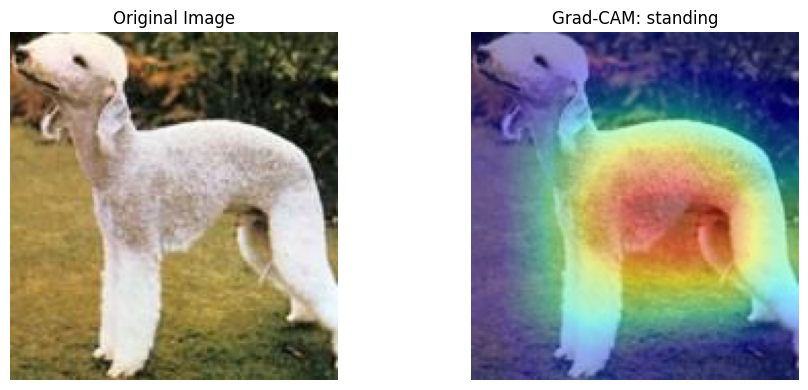

In [ ]:
# 13) Grad-CAM visualization for dog pose classifier (ResNet18)

# Where to save Grad-CAM images
gradcam_dir = Path(output_dir) / "gradcam_examples"
gradcam_dir.mkdir(parents=True, exist_ok=True)
print(f"Grad-CAM images will be saved to: {gradcam_dir}")

def generate_gradcam_for_image(
    model,
    img_path,
    class_names,
    eval_transform,
    device,
    target_class_idx=None,
    save_name=None,
):
    """
    Compute Grad-CAM for a single image and overlay it on top of the original.
    """

    model.eval()

    # ---- 1. Load and preprocess image ----
    orig_img = Image.open(img_path).convert("RGB")
    orig_w, orig_h = orig_img.size

    # Apply eval_transform to match model input
    input_tensor = eval_transform(orig_img)  # [C,H,W]
    input_tensor = input_tensor.unsqueeze(0).to(device)  # [1,C,H,W]

    # ---- 2. Register hooks on the last conv block (layer4[-1]) ----
    # For ResNet18, layer4[-1] is a good Grad-CAM target
    target_layer = model.layer4[-1]

    activations = None
    gradients = None

    def forward_hook(module, inputs, output):
        nonlocal activations
        activations = output.detach()  # [1, C, H', W']

    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0].detach()  # [1, C, H', W']

    fh = target_layer.register_forward_hook(forward_hook)
    bh = target_layer.register_backward_hook(backward_hook)

    # ---- 3. Forward pass ----
    outputs = model(input_tensor)  # [1, num_classes]
    probs = F.softmax(outputs, dim=1)[0].detach().cpu().numpy()
    pred_class = int(outputs.argmax(dim=1).item())

    if target_class_idx is None:
        target_class_idx = pred_class

    print(f"Predicted class: {class_names[pred_class]} "
          f"(prob={probs[pred_class]:.3f}), "
          f"target for Grad-CAM: {class_names[target_class_idx]}")

    # ---- 4. Backward pass w.r.t. target class ----
    model.zero_grad()
    one_hot = torch.zeros_like(outputs).to(device)
    one_hot[0, target_class_idx] = 1.0
    outputs.backward(gradient=one_hot)

    # ---- 5. Compute Grad-CAM ----
    # activations: [1, C, H', W']
    # gradients:   [1, C, H', W']
    weights = gradients.mean(dim=(2, 3), keepdim=True)        # [1, C, 1, 1]
    cam = (weights * activations).sum(dim=1, keepdim=True)    # [1, 1, H', W']
    cam = F.relu(cam)

    # Normalize to [0,1]
    cam = cam - cam.min()
    if cam.max() > 0:
        cam = cam / cam.max()

    # Upsample to original image size
    cam = F.interpolate(cam, size=(orig_h, orig_w), mode="bilinear", align_corners=False)
    cam = cam[0, 0].cpu().numpy()  # [H, W]

    # ---- 6. Overlay heatmap on original image ----
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # Show original
    ax[0].imshow(orig_img)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # Overlay Grad-CAM
    ax[1].imshow(orig_img)
    ax[1].imshow(cam, cmap="jet", alpha=0.4)
    ax[1].set_title(f"Grad-CAM: {class_names[target_class_idx]}")
    ax[1].axis("off")

    plt.tight_layout()

    # Save if requested
    if save_name is not None:
        out_path = gradcam_dir / save_name
        plt.savefig(out_path, bbox_inches="tight")
        print(f"Saved Grad-CAM to: {out_path}")

    plt.show()

    # Cleanup hooks
    fh.remove()
    bh.remove()


# ---- Helper: run Grad-CAM on a random test image ----
def gradcam_random_test_example():
    idx = random.randint(0, len(X_test) - 1)
    img_name = X_test.iloc[idx]["image"]
    img_path = os.path.join(images_dir, img_name)

    print(f"\nRunning Grad-CAM for test index {idx}, file: {img_name}")
    generate_gradcam_for_image(
        model,
        img_path,
        class_names=class_names,
        eval_transform=eval_transform,
        device=device,
        target_class_idx=None,
        save_name=f"gradcam_test_{idx:04d}.png",
    )


Running Grad-CAM for test index 228, file: n02107574-Greater_Swiss_Mountain_dog/n02107574_656.jpg
Predicted class: sitting (prob=0.972), target for Grad-CAM: sitting
Saved Grad-CAM to: dog_pose_data/gradcam_examples/gradcam_test_0228.png


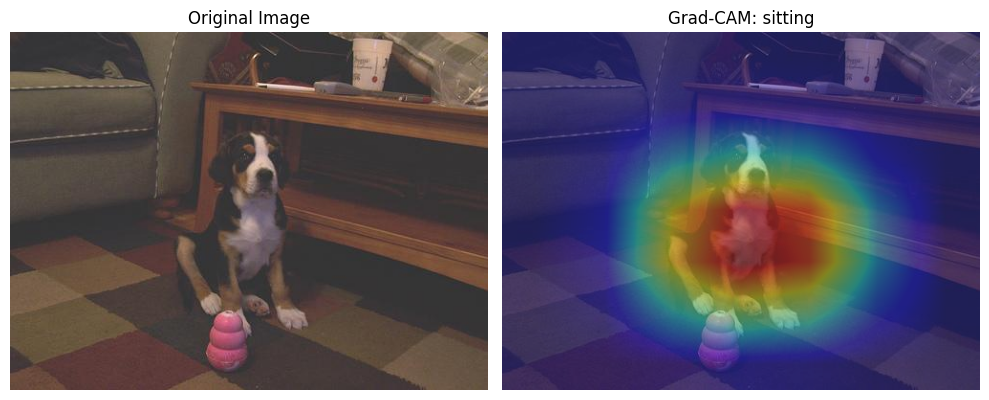

In [ ]:
# ---- Example usage: call this to see a random Grad-CAM ----
gradcam_random_test_example()


In [ ]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 12a) Evaluation setup

import os
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
)

eval_dir = Path(output_dir) / "eval_artifacts"
mis_dir = eval_dir / "misclassified"
eval_dir.mkdir(parents=True, exist_ok=True)
mis_dir.mkdir(parents=True, exist_ok=True)

print(f"Saving evaluation artifacts to: {eval_dir}")


Saving evaluation artifacts to: dog_pose_data/eval_artifacts


In [ ]:
# 12b) Run model on test set

model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device).long()

        outputs = model(inputs)
        _, preds = outputs.max(1)

        all_preds.extend(preds.cpu().tolist())
        all_targets.extend(targets.cpu().tolist())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

overall_acc = float((all_preds == all_targets).mean())
print(f"\nOverall test accuracy: {overall_acc:.4f}")



Overall test accuracy: 0.8984



Classification report:

              precision    recall  f1-score   support

     sitting       0.80      0.87      0.84       376
    standing       0.97      0.89      0.93       881
       lying       0.87      0.93      0.90       514

    accuracy                           0.90      1771
   macro avg       0.88      0.90      0.89      1771
weighted avg       0.90      0.90      0.90      1771



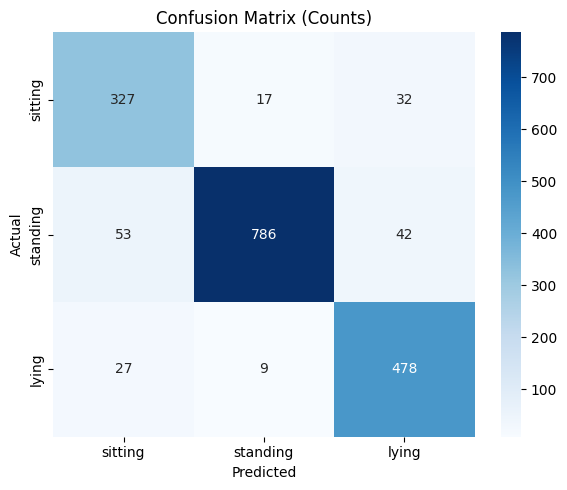

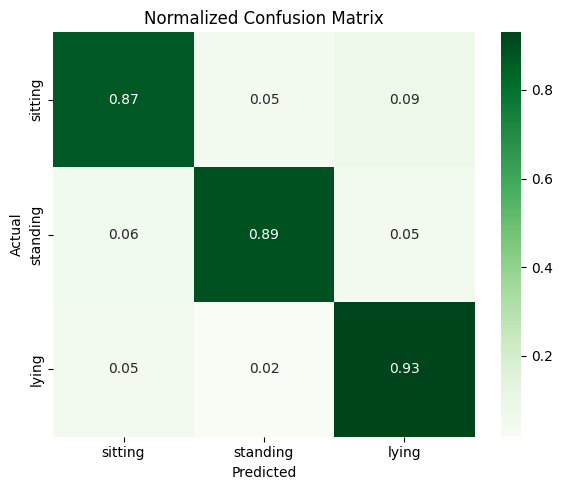


Saved confusion matrix images to:
  dog_pose_data/eval_artifacts/confusion_matrix.png
  dog_pose_data/eval_artifacts/confusion_matrix_normalized.png


In [ ]:
# 12c) Classification report + confusion matrices

# Text report
report_dict = classification_report(
    all_targets,
    all_preds,
    target_names=class_names,
    output_dict=True,
    zero_division=0,
)

print("\nClassification report:\n")
print(classification_report(all_targets, all_preds, target_names=class_names, zero_division=0))

# Confusion matrices
cm = confusion_matrix(all_targets, all_preds)
cm_norm = confusion_matrix(all_targets, all_preds, normalize="true")

# Raw counts heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.title("Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
cm_path = eval_dir / "confusion_matrix.png"
plt.savefig(cm_path, bbox_inches="tight")
plt.show()

# Normalized heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Greens",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
cm_norm_path = eval_dir / "confusion_matrix_normalized.png"
plt.savefig(cm_norm_path, bbox_inches="tight")
plt.show()

print(f"\nSaved confusion matrix images to:\n  {cm_path}\n  {cm_norm_path}")


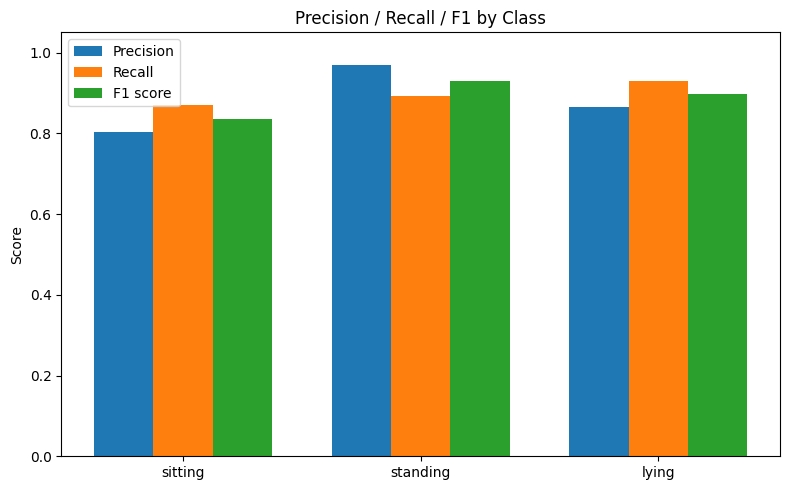

Saved PR/F1 bar chart to:
  dog_pose_data/eval_artifacts/precision_recall_f1.png


In [ ]:
# 12d) Precision / Recall / F1 bar chart

prec, rec, f1, support = precision_recall_fscore_support(
    all_targets, all_preds, zero_division=0
)

x = np.arange(len(class_names))
width = 0.25

plt.figure(figsize=(8, 5))
plt.bar(x - width, prec, width, label="Precision")
plt.bar(x,         rec,  width, label="Recall")
plt.bar(x + width, f1,   width, label="F1 score")

plt.xticks(x, class_names)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Precision / Recall / F1 by Class")
plt.legend()
plt.tight_layout()
prf_path = eval_dir / "precision_recall_f1.png"
plt.savefig(prf_path, bbox_inches="tight")
plt.show()

print(f"Saved PR/F1 bar chart to:\n  {prf_path}")


In [ ]:
# 12f) Save metrics JSON for Streamlit

metrics = {
    "overall_accuracy": overall_acc,
    "per_class": {
        cls: {
            "precision": float(prec[i]),
            "recall": float(rec[i]),
            "f1": float(f1[i]),
            "support": int(support[i]),
        }
        for i, cls in enumerate(class_names)
    },
    "confusion_matrix": cm.tolist(),
    "confusion_matrix_normalized": cm_norm.tolist(),
    "classification_report": report_dict,
}

metrics_path = eval_dir / "metrics.json"
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)

print(f"\nSaved metrics JSON to:\n  {metrics_path}")



Saved metrics JSON to:
  dog_pose_data/eval_artifacts/metrics.json
